In [1]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
import torch
import pandas as pd
from src import util
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from peft import LoraConfig, get_peft_model

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", 
                                  cache_dir="model", local_files_only=True)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", 
                                          cache_dir="model", local_files_only=True)
model = model.to(device)

/home/user/miniforge3/envs/hf/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
data_dir = "data"
articles = pd.read_csv(f"{data_dir}/articles_filtered.csv")

In [4]:
# map from article_id to df index
article_id_to_idx = {article_id: idx for idx, article_id in enumerate(articles["article_id"])}

# get all classes of the dataframe
class_names = articles.columns.tolist()
label_names = dict()
label_names_to_idx = dict()
for class_name in class_names:
    label_names[class_name] = articles[class_name].unique()
    label_names_to_idx[class_name] = {label_name: idx for idx, label_name in enumerate(label_names[class_name])}

article_ids = label_names["article_id"]
selected_class_names = ["product_group_name", "product_type_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]

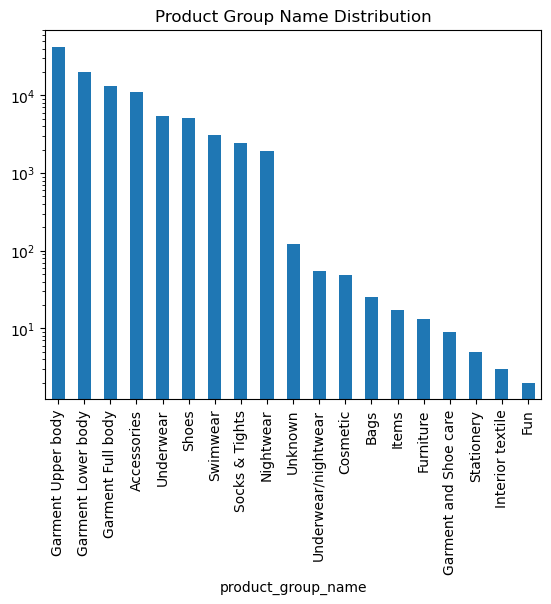

In [5]:
# show distribution on product_group_name
product_group_name_cnts = articles["product_group_name"].value_counts()
product_group_name_cnts.plot(kind="bar", title="Product Group Name Distribution")
plt.yscale("log")
plt.show()

In [6]:
# get label names in product group name with less than 10 samples
product_group_name_cnts = articles["product_group_name"].value_counts()
removed_label_names = product_group_name_cnts[product_group_name_cnts < 10]

# remove data with the removed label name
removed_label_idxs = articles[articles["product_group_name"].isin(removed_label_names.index)].index
articles = articles.drop(removed_label_idxs)

In [7]:
image_paths, labels = util.get_image_paths_and_labels_from_df(articles, data_dir)
print(f"Number of images: {len(image_paths)}")

Number of images: 105081


In [8]:
# strafity with product_group_name
product_group_name = [label["product_group_name"] for label in labels]
# split 0.6/0.2/0.2
train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    image_paths, product_group_name, stratify=product_group_name, test_size=0.4, random_state=42)
val_image_paths, test_image_paths, val_labels, test_labels = train_test_split(
    test_image_paths, test_labels, stratify=test_labels, test_size=0.5, random_state=42)

In [9]:
# Define LoRA configuration
lora_config = LoraConfig(
    r=8,                  # Low-rank dimension (adjustable)
    lora_alpha=32,          # Scaling factor (adjustable)
    target_modules=["q_proj", "v_proj"],  # Specify which layers to apply LoRA to
    lora_dropout=0.1,       # Dropout rate (optional)
    bias="none",            # Whether to include biases ("none", "all", "lora_only")
    task_type="classification"  # Task type ("classification" or "regression")
)

# Apply LoRA to the CLIP model
model = get_peft_model(model, lora_config)

In [10]:
train_dataset = util.ImageDataset(train_image_paths, processor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criteria = torch.nn.CrossEntropyLoss()

model.to(device)

class_name = "product_group_name"

# print trainable parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

base_model.model.text_model.encoder.layers.0.self_attn.v_proj.lora_A.default.weight
base_model.model.text_model.encoder.layers.0.self_attn.v_proj.lora_B.default.weight
base_model.model.text_model.encoder.layers.0.self_attn.q_proj.lora_A.default.weight
base_model.model.text_model.encoder.layers.0.self_attn.q_proj.lora_B.default.weight
base_model.model.text_model.encoder.layers.1.self_attn.v_proj.lora_A.default.weight
base_model.model.text_model.encoder.layers.1.self_attn.v_proj.lora_B.default.weight
base_model.model.text_model.encoder.layers.1.self_attn.q_proj.lora_A.default.weight
base_model.model.text_model.encoder.layers.1.self_attn.q_proj.lora_B.default.weight
base_model.model.text_model.encoder.layers.2.self_attn.v_proj.lora_A.default.weight
base_model.model.text_model.encoder.layers.2.self_attn.v_proj.lora_B.default.weight
base_model.model.text_model.encoder.layers.2.self_attn.q_proj.lora_A.default.weight
base_model.model.text_model.encoder.layers.2.self_attn.q_proj.lora_B.default

In [12]:
losses = []

for epoch in range(2):  # Change number of epochs as needed
    model.train()
    for images, image_ids in tqdm(train_dataloader):
        # Get inputs and move to the appropriate device
        images = images.to(device)
        text_inputs = processor(text=[f"A photo of a {label}" for label in label_names[class_name]], 
                                return_tensors="pt", padding=True)
        text_inputs = text_inputs.to(device)

        # Forward pass
        outputs = model(**text_inputs, pixel_values=images)

        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

        # Get the indices of the labels
        true_labels = [label_names_to_idx[class_name][articles.loc[article_id_to_idx[image_id.item()], class_name]] 
                       for image_id in image_ids]
        true_labels = torch.tensor(true_labels)
        
        # Into one-hot encoding
        y = torch.nn.functional.one_hot(true_labels, num_classes=len(label_names[class_name]))
        
        # Convert into fp32
        y = y.float().to(device)

        loss = criteria(probs, y)
        losses.append(loss.item())

        # Optimizer step
        optimizer.zero_grad()
        loss.backward()

    print(f"Epoch {epoch + 1} completed. Loss: {loss.item()}")

100%|██████████| 1971/1971 [33:34<00:00,  1.02s/it]


Epoch 1 completed. Loss: 2.8856067657470703


100%|██████████| 1971/1971 [33:26<00:00,  1.02s/it]

Epoch 2 completed. Loss: 2.838892936706543


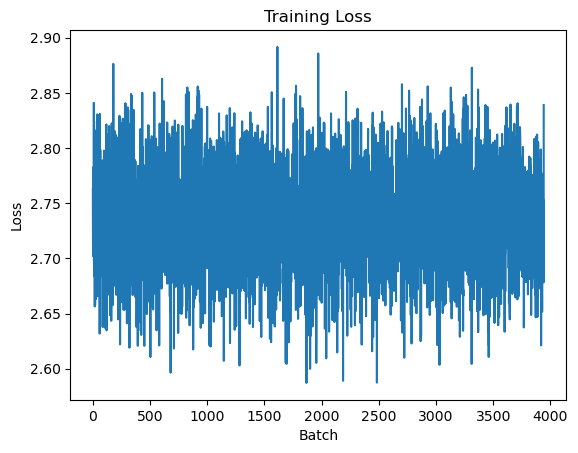

In [13]:
# plot the losses
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()